## PyPSA Introduction Notebook

<div style="display: flex; align-items: center; justify-content: space-between; gap: 1rem; flex-wrap: wrap;">

  <div style="flex: 1; min-width: 250px;">
    <p><strong>Author:</strong><br>
    Priyesh Gosai – Energy Systems Modeler and Training Coordinator</p>
    <p><strong>Contributors:</strong><br>
    Daniel Rüdt – Energy Systems Modeler<br>
    Thomas Gilon – Energy Systems Modeler</p>
  </div>

  <div style="flex: 0 0 auto;">
    <a href="https://openenergytransition.org/index.html" target="_blank">
      <img src="https://openenergytransition.org/assets/img/oet-logo-red-n-subtitle.png" height="60" alt="Open Energy Transition logo">
    </a>
  </div>

</div>


### ⚙️ Setup Environment

**💻 Running in Google Colab**

This notebook is designed to run in **Google Colab**, which provides access to a cloud-based virtual machine. While this is convenient and requires no local setup, it's important to note that **Colab sessions are temporary** — all files and installations are **lost when the session ends**.

To ensure your work is preserved:

- The notebook is set up to **link with your Google Drive**. This allows you to save input files, results, and any model modifications to your own Drive for later use.

- The notebook is also linked to a **GitHub repository**. You can choose whether or not to **pull the latest version of the repository** each time you run the notebook using the boolean options provided below.

  - If enabled, the notebook will:
    - Pull the latest version of the repository into your Drive.
    - Create a backup folder containing your existing work, timestamped for traceability.
    - To avoid cluttering your Google Drive, remember to delete old backups or set the `backup_old_repo = False` option.

Another consideration when using Colab is that **PyPSA and several required packages are not pre-installed** in the Colab environment. These packages must be installed manually each time you connect to a new VM.

For both the GitHub sync and the package installation process, we’ve provided boolean flags that let you **skip these steps** if desired. This gives you more control over the setup process, especially when restarting work or debugging.



**Setup Environment**
1. Provide the path to the repository for this project.
2. Confirm if this is the first run in the Google Colab environment.
3. Confirm if you want to update the repository with the latest changes.

In [1]:
repo_path  = f'https://github.com/open-energy-transition/EIS-2025'
first_run = True # Set to True if this is the first run of the in the Google Colab environment
update_repo = True # Set to True if you want to update the repository with the latest changes

In [ ]:
# @title Connect this Notebook to your Google Drive
# @markdown Run this cell to link this notebook to the GitHub repository. <br>
# @markdown If the repository already exists, it will back up any modified files and force pull the latest changes.
from google.colab import drive
import os
import subprocess
import shutil
from datetime import datetime
import urllib.request

# Mount Google Drive
drive.mount('/content/drive')

# Base directory
base_dir = '/content/drive/MyDrive/'
os.chdir(base_dir)

FOLDER = os.path.basename(repo_path)


if update_repo:


    # Get timestamp
    timestamp = datetime.now().strftime("%Y%m%d_%H%M")
    backup_folder = f'Backup_{timestamp}'
    backup_path = os.path.join(base_dir, backup_folder)

    # If repo exists, back up and force pull
    if os.path.exists(repo_path):
        os.chdir(repo_path)

        # Get list of modified and untracked files
        result = subprocess.run(['git', 'status', '--porcelain'], stdout=subprocess.PIPE, text=True)
        changed_files = [line[3:] for line in result.stdout.splitlines() if line and line[0] in ('M', 'A', '??')]

        if changed_files:
            os.makedirs(backup_path, exist_ok=True)
            print(f"Backing up {len(changed_files)} changed files to {backup_folder}...")
            for file in changed_files:
                src = os.path.join(repo_path, file)
                dst = os.path.join(backup_path, file)
                os.makedirs(os.path.dirname(dst), exist_ok=True)
                if os.path.exists(src):
                    shutil.copy2(src, dst)

        # Force pull: reset local repo to match remote
        subprocess.run(['git', 'fetch', 'origin'])
        subprocess.run(['git', 'reset', '--hard', 'origin/main'])

    else:
        os.chdir(base_dir)
        subprocess.run(['git', 'clone', repo_path])

    
    files = {
        "network_blank.xlsx": "17haq369Y7-5JFRjESfDbUUljVyIEUS4u",  # file ID
        "network_south_africa.xlsx": "1hBqZjotxDuZOQb-kkC0JePbc3gxCGcwq",  # file ID
    }

    for name, file_id in files.items():
        print(f"Retrieving {name} from Google Drive")
        url = f"https://docs.google.com/uc?export=download&id={file_id}"
        urllib.request.urlretrieve(url, name)

    print("Current working directory:", os.getcwd())

In [ ]:
# @title Install the required packages
# @markdown Run this cell to install the necessary Python packages for the project.
if first_run:
    import subprocess, sys, importlib

    packages = [
        "pypsa",        # power‑system modelling & optimization toolbox :contentReference[oaicite:1]{index=1}
        "pypsa[excel]", # pypsa with Excel I/O support
        "folium",       # interactive leaflet‑based maps in Python
        "atlite",       # convert weather reanalysis into energy time‑series :contentReference[oaicite:2]{index=2}
        "pandas",       # tabular data manipulation
        "geopandas",    # pandas + GIS/spatial data support
        "xarray",       # multi‑dim labeled array handling (e.g. gridded data)
        "matplotlib",   # foundational 2D plotting library
        "hvplot",       # high‑level interactive plotting API built on HoloViews
        "geoviews",     # geographic plotting extension for HoloViews
        "plotly",       # interactive plots and dashboards
        "highspy",      # Python wrapper for the high‑performance HiGHS optimizer :contentReference[oaicite:3]{index=3}
        "holoviews",    # declarative visualization library for complex plots
        "mapclassify"   # spatial data classification schemes for choropleth maps
    ]

    subprocess.run(
        [sys.executable, "-m", "pip", "install", "-q", *packages],
        check=True
    )

    missing = [p for p in packages if importlib.util.find_spec(p.split("[")[0]) is None]
    print("✅ All installed!" if not missing else f"❌ Missing: {', '.join(missing)}")


### 🧭 Navigating the PyPSA Object

**Initialize the PyPSA Network** <br>
This cell initializes a PyPSA network  using the meshed AC/DC example.

In [ ]:
import pypsa
import pandas as pd
pd.options.plotting.backend = "plotly"
network = pypsa.examples.ac_dc_meshed()

INFO:pypsa.io:Imported network ac-dc-meshed.nc has buses, carriers, generators, global_constraints, lines, links, loads


To create a blank PyPSA `Network`, use:

```python
network = pypsa.Network()
```

To import an existing network from a supported file format (e.g. HDF5, NetCDF, CSV folder, or Excel), pass the file path:

```python
network = pypsa.Network("filename.xx")
```


Display Network Components

In [5]:
network.components

PyPSA Components Store
- PyPSA 'SubNetwork' Components
- PyPSA 'Bus' Components
- PyPSA 'Carrier' Components
- PyPSA 'GlobalConstraint' Components
- PyPSA 'Line' Components
- PyPSA 'LineType' Components
- PyPSA 'Transformer' Components
- PyPSA 'TransformerType' Components
- PyPSA 'Link' Components
- PyPSA 'Load' Components
- PyPSA 'Generator' Components
- PyPSA 'StorageUnit' Components
- PyPSA 'Store' Components
- PyPSA 'ShuntImpedance' Components
- PyPSA 'Shape' Components

In [6]:
# @title Component naming conventions
# @markdown PyPSA follows Python conventions: 
# @markdown   - PascalCase for component classes. 
# @markdown   - snake_case for attributes and methods.


for key in network.component_attrs:
    print(f'{key.ljust(20)} {network.components[key]["list_name"]}')

SubNetwork           sub_networks
Bus                  buses
Carrier              carriers
GlobalConstraint     global_constraints
Line                 lines
LineType             line_types
Transformer          transformers
TransformerType      transformer_types
Link                 links
Load                 loads
Generator            generators
StorageUnit          storage_units
Store                stores
ShuntImpedance       shunt_impedances
Shape                shapes


**Accessing Component Attributes**

We can also access the component attributes directly:

In the next cell, change the `ComponentName` using PascalCase as a string to view the attributes

In [7]:
ComponentName = 'Generator' 
# ComponentName = 'Bus'
# ComponentName = 'Link'
# ComponentName = 'Line'
# ComponentName = 'Carrier'

network.component_attrs[ComponentName ]

,type,unit,default,description,status,static,varying,typ,dtype
attribute,,,,,,,,,
name,string,NaN,,Unique name,Input (required),True,False,<class 'str'>,object
bus,string,NaN,,name of bus to which generator is attached,Input (required),True,False,<class 'str'>,object
control,string,NaN,PQ,"P,Q,V control strategy for PF, must be ""PQ"", ""...",Input (optional),True,False,<class 'str'>,object
type,string,NaN,,Placeholder for generator type. Not yet implem...,Input (optional),True,False,<class 'str'>,object
p_nom,float,MW,0.0,Nominal power for limits in optimization.,Input (optional),True,False,<class 'float'>,float64
p_nom_mod,float,MW,0.0,Nominal power of the generator module.,Input (optional),True,False,<class 'float'>,float64
p_nom_extendable,boolean,NaN,False,Switch to allow capacity p_nom to be extended ...,Input (optional),True,False,<class 'bool'>,bool
p_nom_min,float,MW,0.0,"If p_nom is extendable in optimization, set it...",Input (optional),True,False,<class 'float'>,float64
p_nom_max,float,MW,inf,"If p_nom is extendable in optimization, set it...",Input (optional),True,False,<class 'float'>,float64


In [8]:
# @title List of Methods in the Network Object
# @markdown This cell lists all the methods available in the `pypsa.Network` object.
# @markdown You can use these methods to interact with the network object.  
# @markdown The methods are displayed in a grid format for better readability.

import inspect

methods = sorted(
    name for name, func in inspect.getmembers(network, inspect.ismethod)
    if not name.startswith("_")
)

n_cols = 3
n_rows = (len(methods) + n_cols - 1) // n_cols
col_width = max(len(m) for m in methods) + 2

for row_idx in range(n_rows):
    for col_idx in range(n_cols):
        idx = col_idx * n_rows + row_idx
        if idx < len(methods):
            print(methods[idx].ljust(col_width), end="")
    print()


add                               get_active_assets                 iterate_components                
adjacency_matrix                  get_committable_i                 lpf                               
branches                          get_extendable_i                  lpf_contingency                   
calculate_dependent_values        get_non_extendable_i              madd                              
component                         get_switchable_as_dense           merge                             
consistency_check                 graph                             mremove                           
controllable_branches             import_components_from_dataframe  passive_branches                  
copy                              import_from_csv_folder            pf                                
determine_network_topology        import_from_excel                 pnl                               
df                                import_from_hdf5                  read_

**View the signature, docstring, and source location.**

You can view the description of a specific method by changing the `method_name` variable.

In [9]:
network.add?

Signature:
network.add(
    class_name: 'str',
    name: 'str | int | Sequence[int | str]',
    suffix: 'str' = '',
    overwrite: 'bool' = False,
    **kwargs: 'Any',
) -> 'pd.Index'
Docstring:
Add components to the network.

Handles addition of single and multiple components along with their attributes.
Pass a list of names to add multiple components at once or pass a single name
to add a single component.

When a single component is added, all non-scalar attributes are assumed to be
time-varying and indexed by snapshots.
When multiple components are added, all non-scalar attributes are assumed to be
static and indexed by names. A single value sequence is treated as scalar and
broadcasted to all components. It is recommended to explicitly pass a scalar
instead.
If you want to add time-varying attributes to multiple components, you can pass
a 2D array/ DataFrame where the first dimension is snapshots and the second
dimension is names.

Any attributes which are not specified will be gi

**Explore the Network**

This cell provides an interactive map of the network using the `explore` method using Folium.


In [10]:
network.plot.explore()

INFO:pypsa.plot.maps.interactive:Components rendered on the map: Bus, Line, Link.
INFO:pypsa.plot.maps.interactive:Components omitted as they are missing or not selected: Generator, Load, StorageUnit, Transformer.


We can create the model without solving it. 

In [11]:
network.optimize.create_model()

Index(['2', '3', '4'], dtype='object', name='Line')
Index(['0', '1', '5', '6'], dtype='object', name='Line')


Linopy LP model

Variables:
----------
 * Generator-p_nom (Generator-ext)
 * Line-s_nom (Line-ext)
 * Link-p_nom (Link-ext)
 * Generator-p (snapshot, Generator)
 * Line-s (snapshot, Line)
 * Link-p (snapshot, Link)
 * objective_constant

Constraints:
------------
 * Generator-ext-p_nom-lower (Generator-ext)
 * Generator-ext-p_nom-upper (Generator-ext)
 * Line-ext-s_nom-lower (Line-ext)
 * Line-ext-s_nom-upper (Line-ext)
 * Link-ext-p_nom-lower (Link-ext)
 * Link-ext-p_nom-upper (Link-ext)
 * Generator-ext-p-lower (snapshot, Generator-ext)
 * Generator-ext-p-upper (snapshot, Generator-ext)
 * Line-ext-s-lower (snapshot, Line-ext)
 * Line-ext-s-upper (snapshot, Line-ext)
 * Link-ext-p-lower (snapshot, Link-ext)
 * Link-ext-p-upper (snapshot, Link-ext)
 * Bus-nodal_balance (Bus, snapshot)
 * Kirchhoff-Voltage-Law (snapshot, cycles)
 * GlobalConstraint-co2_limit

Status:
-------
initialized

We can view the constraints.

In [12]:
network.model

Linopy LP model

Variables:
----------
 * Generator-p_nom (Generator-ext)
 * Line-s_nom (Line-ext)
 * Link-p_nom (Link-ext)
 * Generator-p (snapshot, Generator)
 * Line-s (snapshot, Line)
 * Link-p (snapshot, Link)
 * objective_constant

Constraints:
------------
 * Generator-ext-p_nom-lower (Generator-ext)
 * Generator-ext-p_nom-upper (Generator-ext)
 * Line-ext-s_nom-lower (Line-ext)
 * Line-ext-s_nom-upper (Line-ext)
 * Link-ext-p_nom-lower (Link-ext)
 * Link-ext-p_nom-upper (Link-ext)
 * Generator-ext-p-lower (snapshot, Generator-ext)
 * Generator-ext-p-upper (snapshot, Generator-ext)
 * Line-ext-s-lower (snapshot, Line-ext)
 * Line-ext-s-upper (snapshot, Line-ext)
 * Link-ext-p-lower (snapshot, Link-ext)
 * Link-ext-p-upper (snapshot, Link-ext)
 * Bus-nodal_balance (Bus, snapshot)
 * Kirchhoff-Voltage-Law (snapshot, cycles)
 * GlobalConstraint-co2_limit

Status:
-------
initialized

**Optimize the Network**

This cell runs the optimization on the network. The default solver is HiGHS, which is a high-performance open-source solver for linear programming problems.

You can change the solver by modifying the `solver_name` parameter in the `network.optimize()` method.

Additional advanced features in PyPSA may be of interest to some users, including support for [custom constraints](https://pypsa.readthedocs.io/en/latest/user-guide/optimal-power-flow.html#custom-constraints), [rolling horizon optimization](https://pypsa.readthedocs.io/en/latest/user-guide/optimal-power-flow.html#rolling-horizon-optimization), and several other modeling options. 

For a full overview, visit the [System Optimization](https://pypsa.readthedocs.io/en/latest/user-guide/optimal-power-flow.html#) section of the PyPSA documentation.


In [13]:
network.optimize()

Index(['2', '3', '4'], dtype='object', name='Line')
Index(['0', '1', '5', '6'], dtype='object', name='Line')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.07s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 188 primals, 468 duals
Objective: -3.47e+06
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Line-ext-s-lower, Line-ext-s-upper, Link-ext-p-lower, Link-ext-p-upper, Kirchhoff-Voltage-Law were not assigned to the network.


('ok', 'optimal')

In the next section we look at the inputs and outputs for this network.

---

### 🗃️ Data in the PyPSA Object

In [14]:
# @title Download prepared networks
# @markdown We have prepared a case study that can be explored in this notebook. The case is based on the electircity network from PyPSA-EUR. To allow users to interact with the data we have prepared two networks. One before the optimization and another after the optimization. Running this optimization is a computationally expensive task. 
# @markdown * `pre-network.nc`: The network is prepared before solving it. 
# @markdown * `post-network.nc`: The solved network

from urllib.request import urlretrieve

urls = {
    "pre-network.nc": "https://drive.usercontent.google.com/download?id=17b7YZGXKczY2K5sRPUDJkD5AVwgbOgAh&export=download",
    "post-network.nc": "https://drive.usercontent.google.com/download?id=1qIN0tlZBACPtKCBxHUpBAecBqYsy-sTV&export=download&confirm=t&uuid=cf9cb5cf-de33-4ef4-9f49-5f01f2d571b1",
    }
for name, url in urls.items():
    print(f"Retrieving {name} from Google Drive")
    urlretrieve(url, name)
print("Done")

Retrieving pre-network.nc from Google Drive
Retrieving post-network.nc from Google Drive
Done


Import the `pre-network` to an object called `network_eur`

In [15]:
pre_network_eur = pypsa.Network("pre-network.nc")

INFO:pypsa.io:Imported network pre-network.nc has buses, carriers, generators, global_constraints, links, loads, shapes, storage_units, stores


Inspect the data in the network. 

_All data in a PyPSA model is stored as pandas DataFrames, allowing you to apply any standard pandas operations directly to PyPSA network components._

In [16]:
pre_network_eur.buses

,v_nom,type,x,y,carrier,unit,location,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,generator,sub_network,substation_lv,country,substation_off
Bus,,,,,,,,,,,,,,,,
AL00,380.0,,20.036884,41.117588,AC,MWh_el,AL00,1.0,0.0,inf,PQ,,,1.0,AL,1.0
AT00,380.0,,14.822183,47.668898,AC,MWh_el,AT00,1.0,0.0,inf,PQ,,,1.0,AT,1.0
BA00,380.0,,17.867837,43.982016,AC,MWh_el,BA00,1.0,0.0,inf,PQ,,,1.0,BA,1.0
BE00,380.0,,4.967931,50.470635,AC,MWh_el,BE00,1.0,0.0,inf,PQ,,,1.0,BE,1.0
BG00,380.0,,25.323948,42.668760,AC,MWh_el,BG00,1.0,0.0,inf,PQ,,,1.0,BG,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SI00 urban decentral water tanks,1.0,,14.565063,46.195746,urban decentral water tanks,MWh_th,SI00,1.0,0.0,inf,PQ,,,NaN,SI,NaN
SK00 rural heat,1.0,,18.778426,48.645144,rural heat,MWh_th,SK00,1.0,0.0,inf,PQ,,,NaN,SK,NaN
SK00 rural water tanks,1.0,,18.778426,48.645144,rural water tanks,MWh_th,SK00,1.0,0.0,inf,PQ,,,NaN,SK,NaN


In [17]:
pre_network_eur.generators

,bus,control,type,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,...,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt,unit,location
Generator,,,,,,,,,,,,,,,,,,,,,
AL00 offwind-ac,AL00,PQ,,0.000000,0.0,True,0.000000,3160.441247,0.0,1.0,...,1,0,NaN,NaN,1.0,1.0,1.0,0.0,,
BA00 offwind-ac,BA00,PQ,,0.000000,0.0,True,0.000000,16.871211,0.0,1.0,...,1,0,NaN,NaN,1.0,1.0,1.0,0.0,,
BE00 offwind-ac,BE00,PQ,,1053.971009,0.0,True,1053.971009,1053.971009,0.0,1.0,...,1,0,NaN,NaN,1.0,1.0,1.0,0.0,,
BG00 offwind-ac,BG00,PQ,,0.000000,0.0,True,0.000000,1598.925797,0.0,1.0,...,1,0,NaN,NaN,1.0,1.0,1.0,0.0,,
CY00 offwind-ac,CY00,PQ,,0.000000,0.0,True,0.000000,2057.040496,0.0,1.0,...,1,0,NaN,NaN,1.0,1.0,1.0,0.0,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SI00 urban decentral solar thermal collector,SI00 urban decentral heat,PQ,,0.000000,0.0,True,0.000000,inf,0.0,1.0,...,1,0,NaN,NaN,1.0,1.0,1.0,0.0,,
SK00 rural heat vent,SK00 rural heat,PQ,,0.000000,0.0,True,0.000000,inf,-1.0,0.0,...,1,0,NaN,NaN,1.0,1.0,1.0,0.0,MWh_th,SK00
SK00 rural solar thermal collector,SK00 rural heat,PQ,,0.000000,0.0,True,0.000000,inf,0.0,1.0,...,1,0,NaN,NaN,1.0,1.0,1.0,0.0,,


In [18]:
pre_network_eur.generators_t.p_max_pu.head()

Generator,AL00 offwind-ac,AL00 offwind-float,AL00 onwind,AL00 ror,AL00 rural solar thermal collector,AL00 solar,AL00 solar rooftop,AL00 solar-hsat,AL00 urban central solar thermal collector,AL00 urban decentral solar thermal collector,...,SI00 urban central solar thermal collector,SI00 urban decentral solar thermal collector,SK00 onwind,SK00 ror,SK00 rural solar thermal collector,SK00 solar,SK00 solar rooftop,SK00 solar-hsat,SK00 urban central solar thermal collector,SK00 urban decentral solar thermal collector
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,0.001693,0.000000,0.000000,0.242212,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.393063,0.093045,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2013-01-01 06:00:00,0.005730,0.000000,0.000000,0.243995,0.195022,0.436909,0.436909,0.437030,0.195022,0.195022,...,0.150212,0.150212,0.370897,0.093232,0.097654,0.271007,0.271007,0.256652,0.097654,0.097654
2013-01-01 12:00:00,0.000000,0.000000,0.000000,0.261268,0.056555,0.168575,0.168575,0.176439,0.056555,0.056555,...,0.057245,0.057245,0.211535,0.093165,0.020054,0.098340,0.098340,0.099123,0.020054,0.020054
2013-01-01 18:00:00,0.010752,0.018746,0.000000,0.256900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.101057,0.092820,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2013-01-02 00:00:00,0.055440,0.087569,0.003748,0.253857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.025453,0.092939,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


<Axes: xlabel='snapshot'>

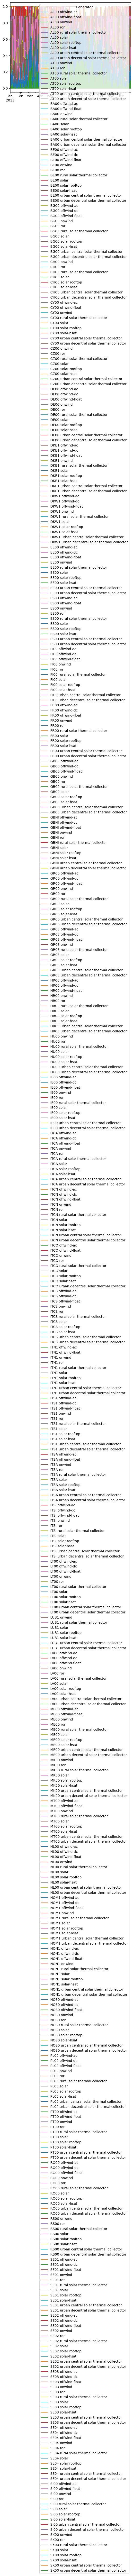

In [19]:
pre_network_eur.generators_t.p_max_pu.plot()

In [20]:
pre_network_eur.links

,bus0,bus1,type,carrier,efficiency,active,build_year,lifetime,p_nom,p_nom_mod,...,underground,geometry,reversed,under_construction,length_original,underwater_fraction,tags,energy to power ratio,location,dc
Link,,,,,,,,,,,,,,,,,,,,,
AL00-GR00-DC,AL00,GR00,,DC,1.00,True,0,inf,600.0,0.0,...,1.0,LINESTRING (20.036883988642362 41.117587702511...,False,0.0,219.635111,0.0,AL00 -> GR00,NaN,,1.0
AL00-ME00-DC,AL00,ME00,,DC,1.00,True,0,inf,400.0,0.0,...,1.0,LINESTRING (20.036883988642362 41.117587702511...,False,0.0,189.342890,0.0,AL00 -> ME00,NaN,,1.0
AL00-MK00-DC,AL00,MK00,,DC,1.00,True,0,inf,500.0,0.0,...,1.0,LINESTRING (20.036883988642362 41.117587702511...,False,0.0,153.308707,0.0,AL00 -> MK00,NaN,,1.0
AL00-RS00-DC,AL00,RS00,,DC,1.00,True,0,inf,250.0,0.0,...,1.0,LINESTRING (20.036883988642362 41.117587702511...,False,0.0,351.420535,0.0,AL00 -> RS00,NaN,,1.0
AT00-CH00-DC,AT00,CH00,,DC,1.00,True,0,inf,1200.0,0.0,...,1.0,LINESTRING (14.822183225330722 47.668898155000...,False,0.0,502.028400,0.0,AT00 -> CH00,NaN,,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SK00 urban decentral biomass boiler,EU solid biomass,SK00 urban decentral heat,,urban decentral biomass boiler,0.86,True,0,20.0,0.0,0.0,...,NaN,,False,NaN,0.000000,NaN,,NaN,,NaN
SK00 urban decentral gas boiler,EU gas,SK00 urban decentral heat,,urban decentral gas boiler,0.98,True,0,20.0,0.0,0.0,...,NaN,,False,NaN,0.000000,NaN,,NaN,,NaN
SK00 urban decentral resistive heater,SK00 low voltage,SK00 urban decentral heat,,urban decentral resistive heater,0.90,True,0,20.0,0.0,0.0,...,NaN,,False,NaN,0.000000,NaN,,NaN,,NaN


In [21]:
pre_network_eur.lines

attribute,bus0,bus1,type,x,r,g,b,s_nom,s_nom_mod,s_nom_extendable,...,v_ang_min,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu,x_pu_eff,r_pu_eff,s_nom_opt
Line,,,,,,,,,,,,,,,,,,,,,


In [22]:
pre_network_eur.loads

,bus,carrier,type,p_set,q_set,sign,active
Load,,,,,,,
AL00,AL00 low voltage,electricity,,0.0,0.0,-1.0,True
AT00,AT00 low voltage,electricity,,0.0,0.0,-1.0,True
BA00,BA00 low voltage,electricity,,0.0,0.0,-1.0,True
BE00,BE00 low voltage,electricity,,0.0,0.0,-1.0,True
BG00,BG00 low voltage,electricity,,0.0,0.0,-1.0,True
...,...,...,...,...,...,...,...
SE04 urban decentral heat,SE04 urban decentral heat,urban decentral heat,,0.0,0.0,-1.0,True
SI00 rural heat,SI00 rural heat,rural heat,,0.0,0.0,-1.0,True
SI00 urban decentral heat,SI00 urban decentral heat,urban decentral heat,,0.0,0.0,-1.0,True


If you wanted to solve the network we could run: 
```python
pre_network_eur.optimize(solver_name = 'gurobi') # Assuming that you have a licence. 
```

The solved network data is imported from the file `post-network.nc`

In [23]:
post_network_eur = pypsa.Network("post-network.nc")

INFO:pypsa.io:Imported network post-network.nc has buses, carriers, generators, global_constraints, links, loads, shapes, storage_units, stores


#### 🧮 Results

---

📊 `pypsa.statistics`

The `pypsa.statistics` module provides a set of high-level functions for analyzing and summarizing the results of PyPSA models. It enables users to compute key metrics such as:

- **Generation mix** by technology  
- **Installed capacity** summaries  
- **Line loading** and **congestion metrics**  
- **Costs and revenues** by component  
- **CO₂ emissions** and carbon intensity  
- **Regional energy balances** and **power flows**

These functions are especially useful for post-processing model results and producing plots or reports for scenario analysis, capacity expansion studies, and policy evaluation.

The module works directly with the PyPSA `Network` object and leverages pandas operations internally, so results are returned as DataFrames that can be easily visualized or exported.




In [24]:
s = post_network_eur.statistics

You can easily have an comprehensive overview of the system level results.

In [25]:
s().head()

Optimal Capacity  Installed Capacity  \
Generator Offshore Wind (AC)             59667.63846          6580.28372   
          Offshore Wind (DC)             79517.60138         13350.65347   
          Offshore Wind (Floating)       26188.43674          5074.35608   
          Onshore Wind                  313677.75700        184845.68700   
          Run of River                   47774.12902         47774.12902   

                                          Supply  Withdrawal  Energy Balance  \
Generator Offshore Wind (AC)        2.336326e+08         0.0    2.336326e+08   
          Offshore Wind (DC)        3.836668e+08         0.0    3.836668e+08   
          Offshore Wind (Floating)  1.057571e+08         0.0    1.057571e+08   
          Onshore Wind              7.470741e+08         0.0    7.470741e+08   
          Run of River              1.704413e+08         0.0    1.704413e+08   

                                    Transmission  Capacity Factor  \
Generator Offshore Wind (AC)                 0.0         0.446983   
          Offshore Wind (DC)                 0.0         0.550791   
          Offshore Wind (Floating)           0.0         0.460994   
          Onshore Wind                       0.0         0.271879   
          Run of River                       0.0         0.407266   

                                     Curtailment  Capital Expenditure  \
Generator Offshore Wind (AC)        1.628091e+07         1.206196e+10   
          Offshore Wind (DC)        7.110183e+06         1.832538e+10   
          Offshore Wind (Floating)  9.206199e+05         6.145530e+09   
          Onshore Wind              1.783103e+07         3.629873e+10   
          Run of River              3.359915e+04         1.472257e+10   

                                    Operational Expenditure       Revenue  \
Generator Offshore Wind (AC)                   5.772445e+06  1.371072e+10   
          Offshore Wind (DC)                   9.456484e+06  2.127265e+10   
          Offshore Wind (Floating)             2.566804e+06  5.906603e+09   
          Onshore Wind                         1.861170e+07  3.442422e+10   
          Run of River                         1.700200e+06  1.066173e+10   

                                    Market Value  
Generator Offshore Wind (AC)           58.684940  
          Offshore Wind (DC)           55.445638  
          Offshore Wind (Floating)     55.850669  
          Onshore Wind                 46.078722  
          Run of River                 62.553712

Let's have a look to optimal renewable capacities.

In [26]:
(
    s.optimal_capacity(
        bus_carrier=["AC", "low voltage"],
        comps="Generator",
    ).div(
        1e3
    )  # GW
)

carrier
Offshore Wind (AC)           59.667638
Offshore Wind (DC)           79.517601
Offshore Wind (Floating)     26.188437
Onshore Wind                313.677757
Run of River                 47.774129
Solar                       152.958181
solar rooftop               694.672489
solar-hsat                   73.592653
dtype: float64

You can get it as fancy as you want!

In [27]:
(
    s.optimal_capacity(
        bus_carrier=["AC", "low voltage"],
        groupby=["location", "carrier"],
        comps="Generator",
    )
    .div(1e3)  # GW
    .to_frame(name="p_nom_opt")
    .pivot_table(index="location", columns="carrier", values="p_nom_opt")
    .fillna(0)
    .assign(Total=lambda df: df.sum(axis=1))
    .sort_values(by="Total", ascending=False)
    .round(2)
).head()

carrier,Offshore Wind (AC),Offshore Wind (DC),Offshore Wind (Floating),Onshore Wind,Run of River,Solar,solar rooftop,solar-hsat,Total
location,,,,,,,,,
DE00,4.24,21.70,0.53,56.42,4.76,53.67,80.41,0.00,221.73
FR00,27.60,6.91,21.12,17.48,6.51,11.06,122.71,0.00,213.39
GB00,8.61,3.28,3.57,81.05,2.87,12.52,42.45,0.00,154.36
ES00,0.00,0.00,0.00,26.81,0.28,10.14,84.74,29.85,151.83
PL00,5.17,5.81,0.00,19.71,0.18,3.95,37.31,0.00,72.13


We can also easily look into the energy balance for a specific carrier by Node. 

So, let's investigate the Hydrogen balance at the Z1 and Z2 nodes of Germany (DE):

In [28]:
df = (
    s.energy_balance(groupby=["bus_carrier", "country", "bus", "carrier", "name"])
    .div(1e6)  # TWh
    .to_frame(name="Balance [TWh]")
    .query(
        "(bus_carrier.str.contains('Hydrogen')) "
        "and (country == 'DE') "
        " and (abs(`Balance [TWh]`) > 1e-2)"
    )
    .round(2)
)
df

Balance [TWh]
component bus_carrier      country bus      carrier         name                                       
Link      Hydrogen Storage DE      DE H2 Z1 H2 pipeline     H2 pipeline DEH2Z1 -> DEH2Z2         -24.18
                                            SMR CC          DE H2 Z1 SMR CC                       24.18
                                   DE H2 Z2 H2 pipeline     H2 pipeline DE -> AT                  -1.72
                                                            H2 pipeline DE -> CZ                  -0.18
                                                            H2 pipeline DE -> FR                  -0.07
                                                            H2 pipeline DE -> IBFI                -0.97
                                                            H2 pipeline DE -> PL                 -21.63
                                                            H2 pipeline DEH2Z1 -> DEH2Z2          24.18
                                                            H2 pipeline DK -> DE                  13.88
                                                            H2 pipeline FR -> DE                   2.59
                                                            H2 pipeline NL -> DE                   1.39
Load      Hydrogen Storage DE      DE H2 Z2 H2 for industry DE00 H2 Z2 for industry              -17.46

In [29]:
# verify energy balance
df.groupby(by="bus").sum()

,Balance [TWh]
bus,
DE H2 Z1,0.00
DE H2 Z2,0.01


In [30]:
exports = df.query("name.str.contains('DE ->')")
export_twh = exports["Balance [TWh]"].sum().round(2)
print(f"DE exports {export_twh} TWh of H2.")

imports = df.query(
    "(name.str.contains('-> DE')) and not (name.str.contains('Z1')) and not (name.str.contains('Z2'))"
)
import_twh = imports["Balance [TWh]"].sum().round(2)
print(f"DE imports {import_twh} TWh of H2.")

balance_twh = import_twh + export_twh
print(
    f"DE is a net {'importer' if balance_twh > 0 else 'exporter'} ({balance_twh.round(2)} TWh)."
)

DE exports -24.57 TWh of H2.
DE imports 17.86 TWh of H2.
DE is a net exporter (-6.71 TWh).


... or look at renewable curtailment in the system:

In [31]:
(
    s.curtailment(
        bus_carrier=["AC", "low voltage"],
        groupby=["location", "carrier"],
    )
    .div(1e6)  # TWh
    .to_frame(name="p_nom_opt")
    .pivot_table(index="location", columns="carrier", values="p_nom_opt")
    .fillna(0)
    .assign(Total=lambda df: df.sum(axis=1))
    .sort_values(by="Total", ascending=False)
    .round(2)
).head()

carrier,Offshore Wind (AC),Offshore Wind (DC),Offshore Wind (Floating),Onshore Wind,Pumped Hydro Storage,Reservoir & Dam,Run of River,Solar,solar rooftop,solar-hsat,Total
location,,,,,,,,,,,
ES00,0.00,0.00,0.00,2.75,84.42,98.52,0.0,0.01,3.22,3.35,192.28
CH00,0.00,0.00,0.00,0.00,48.19,68.73,0.0,0.05,0.36,0.04,117.37
NOS0,0.00,0.00,0.00,0.00,1.53,113.26,0.0,0.00,0.00,0.00,114.79
FR00,5.61,0.93,0.61,0.57,40.16,27.26,0.0,0.01,0.99,0.00,76.15
AT00,0.00,0.00,0.00,0.01,50.25,20.30,0.0,0.01,0.15,0.30,71.02


---
📈 `pypsa.plot`

PyPSA also includes a built-in `pypsa.plot` module that provides a small set of standard plotting functions. These are useful for quickly visualizing key aspects of your network, such as:

- Network topology (buses, lines, generators)
- Line loading and power flows
- Generation dispatch over time
- Installed capacities and time-series data

These plots are useful for exploratory analysis and debugging and can be customized using `matplotlib`.

For more advanced or interactive visualizations, you may consider combining PyPSA outputs with external libraries such as `plotly`, `holoviews`, or `hvplot`.


In [32]:
# let's fill missing colors first
post_network_eur.carriers.loc["none", "color"] = "#000000"
post_network_eur.carriers.loc["", "color"] = "#000000"

Let's now plot the optimal renewable capacities that we investigated before.

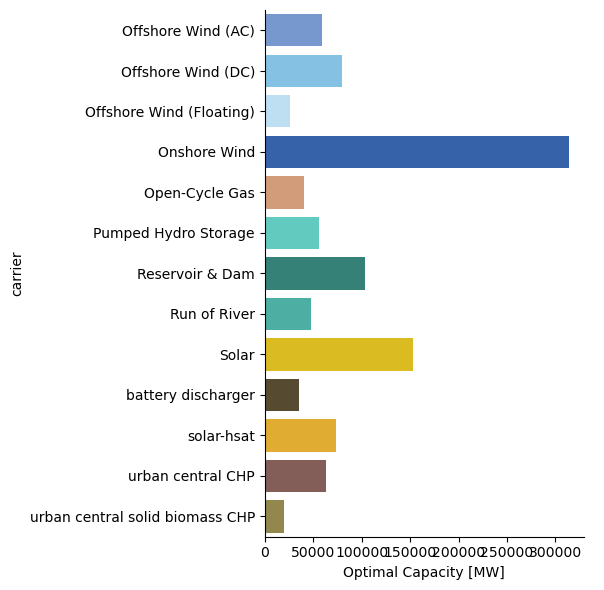

In [33]:
s.optimal_capacity.plot.bar(
    bus_carrier="AC",
    query="value>1e3",
    height=6,
);

You can also have details for specific countries.

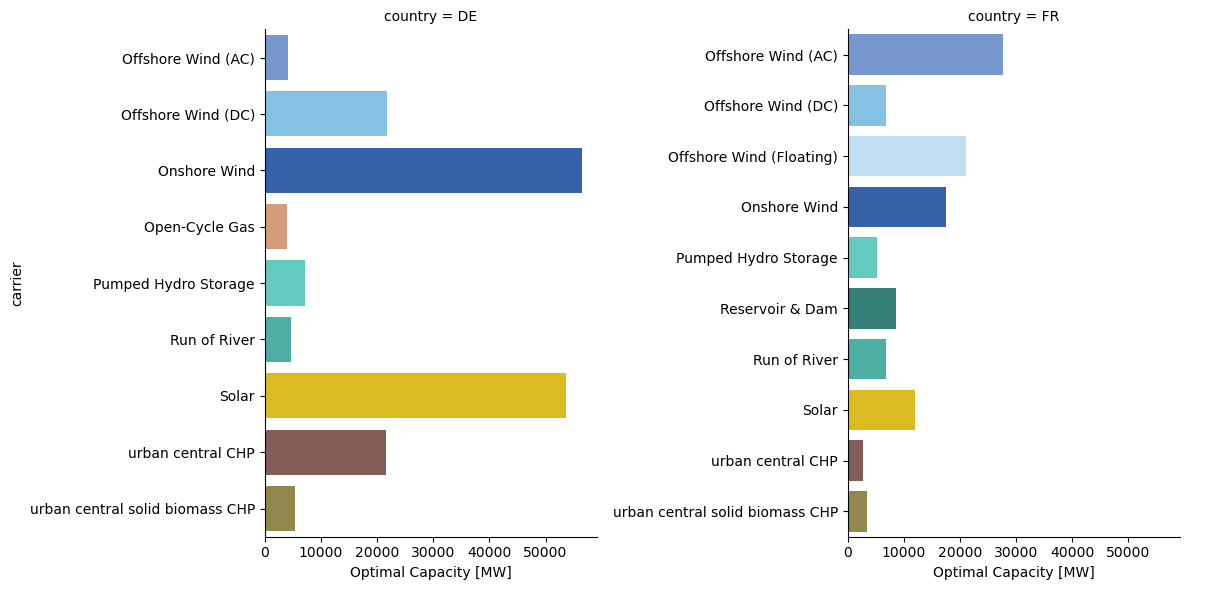

In [34]:
s.optimal_capacity.plot.bar(
    bus_carrier="AC",
    query="value>1e3 and country in ['DE', 'FR']",
    height=6,
    facet_col="country",
);

You can have a closer look to the wind production

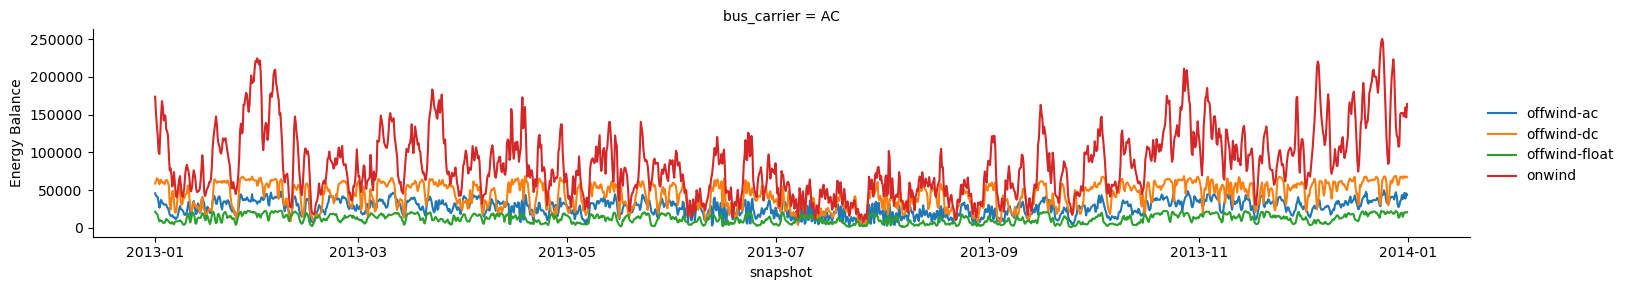

In [35]:
s.energy_balance.plot.line(
    facet_row="bus_carrier",
    y="value",
    x="snapshot",
    carrier="wind",
    nice_names=False,
    color="carrier",
    aspect=5.0,
);

... or to the dispatch for specific countries.

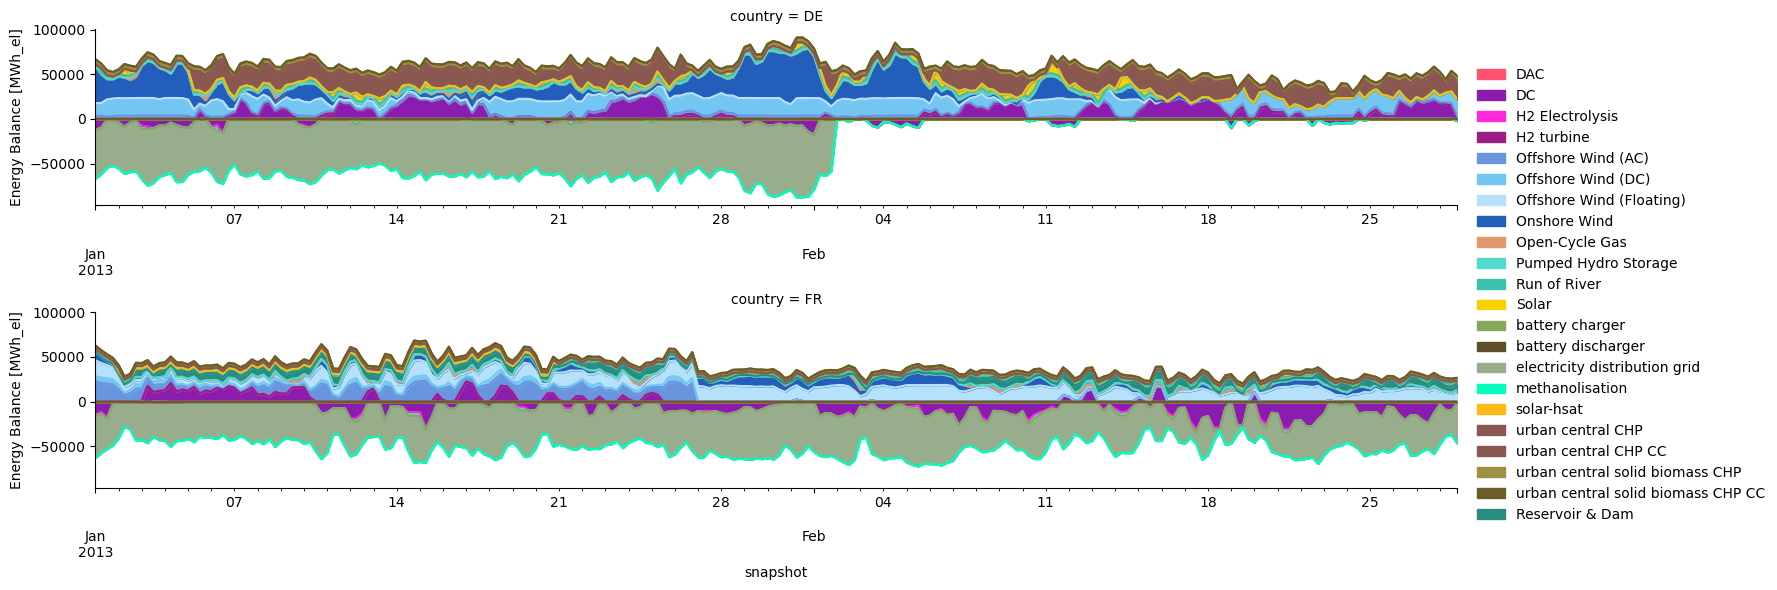

In [36]:
s.energy_balance.plot.area(
    bus_carrier=["AC"],
    y="value",
    x="snapshot",
    color="carrier",
    stacked=True,
    facet_row="country",
    query="country in ['DE', 'FR'] and snapshot < '2013-03'",
    aspect=5,
);

You can also explore H2 results.

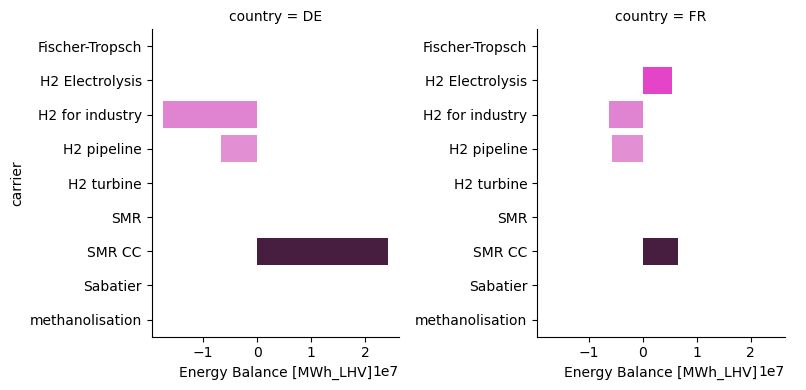

In [37]:
s.energy_balance.plot.bar(
    bus_carrier=["H2"],
    y="carrier",
    x="value",
    color="carrier",
    facet_col="country",
    height=4,
    aspect=1,
    query="country in ['DE', 'FR']",
);

You can also explore the correlation between renewable production and hydrogen.

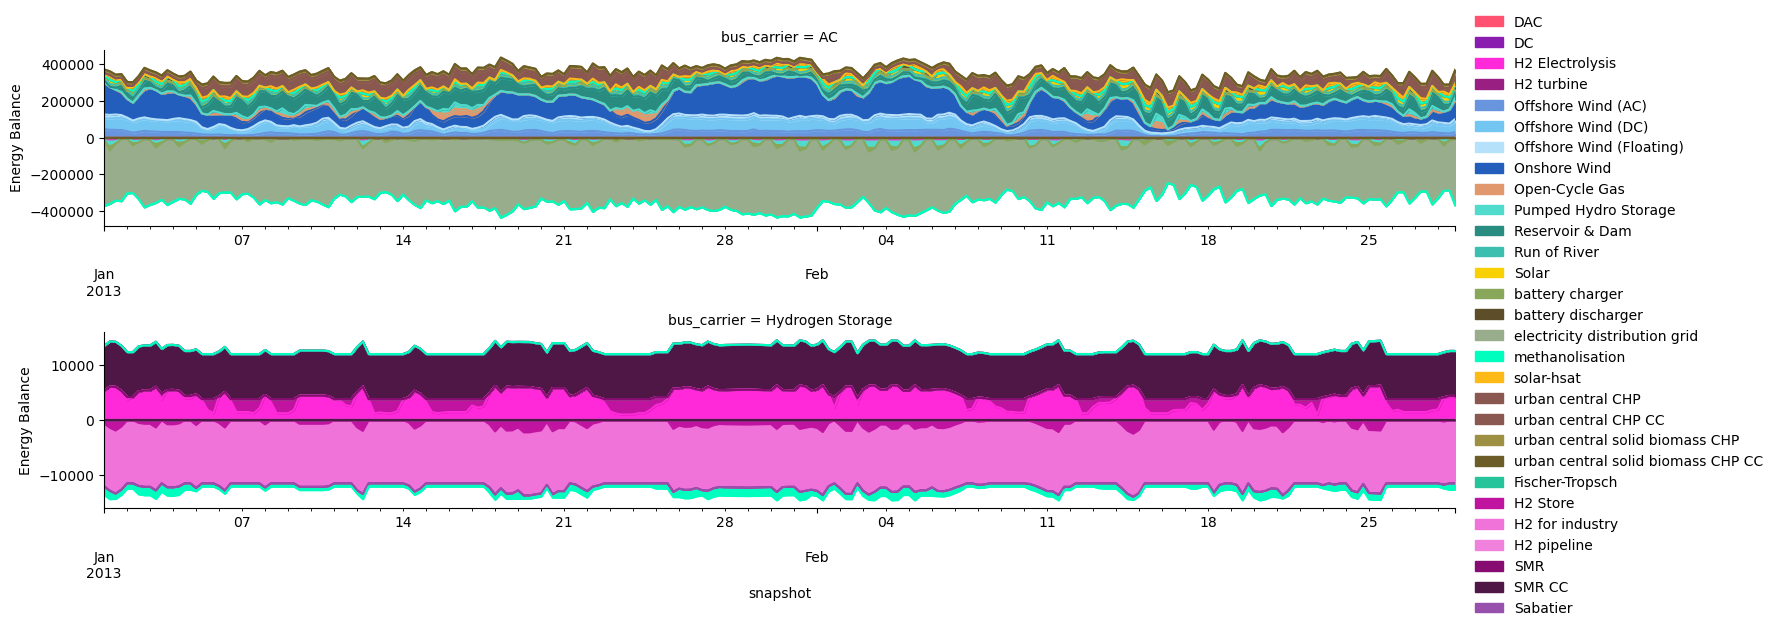

In [38]:
s.energy_balance.plot.area(
    bus_carrier=["AC", "H2"],
    y="value",
    x="snapshot",
    color="carrier",
    stacked=True,
    facet_row="bus_carrier",
    sharex=False,
    sharey=False,
    query="snapshot < '2013-03'",
    aspect=5,
);

### 🚀 Getting started with your own PyPSA Model  

* PyPSA v0.34 introduced support for importing models directly from Excel files, where each sheet is named according to PyPSA's component naming conventions.
* This feature provides an easy starting point for building your first PyPSA model.
* This repository includes:
   * A blank Excel template you can use to start your own model.
   * A completed example model of a simple power system for reference.
        * The model uses nine nodes to represent the South African power system.
        * Interconnected using links to simplify the network structure.
As models grow more complex, it's recommended to adopt a more robust and reproducible workflow for long-term development and collaboration.

To import the excel file


```python 
network_name = pypsa.Network('network_name.xlsx')

```

Explore the South African Example

In [39]:
import pypsa

In [40]:
network_za = pypsa.Network('network_south_africa.xlsx')

INFO:pypsa.io:Imported network network_south_africa has buses, carriers, generators, links, loads, storage_units


In [41]:
network_za.loads

,bus,carrier,type,p_set,q_set,sign,active
Load,,,,,,,
Eastern Cape Load,EC,AC,,0.0,0.0,-1.0,True
Free State Load,FS,AC,,0.0,0.0,-1.0,True
Gauteng Load,GP,AC,,0.0,0.0,-1.0,True
KwaZulu Natal Load,ZN,AC,,0.0,0.0,-1.0,True
Limpopo Load,LP,AC,,0.0,0.0,-1.0,True
Mpumalanga Load,MP,AC,,0.0,0.0,-1.0,True
North West Load,NW,AC,,0.0,0.0,-1.0,True
Northern Cape Load,NC,AC,,0.0,0.0,-1.0,True
Western Cape Load,WC,AC,,0.0,0.0,-1.0,True


In [42]:
network_za.buses # and similarly for other components

,v_nom,type,x,y,carrier,unit,location,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,generator,sub_network
Bus,,,,,,,,,,,,,
EC,1.0,,26.4194,-32.2968,AC,,,1.0,0.0,inf,PQ,,
FS,1.0,,26.8141,-28.4541,AC,,,1.0,0.0,inf,PQ,,
GP,1.0,,28.2184,-26.2708,AC,,,1.0,0.0,inf,PQ,,
ZN,1.0,,30.5595,-28.5306,AC,,,1.0,0.0,inf,PQ,,
LP,1.0,,29.8739,-23.4015,AC,,,1.0,0.0,inf,PQ,,
MP,1.0,,30.4044,-25.5653,AC,,,1.0,0.0,inf,PQ,,
NW,1.0,,25.7906,-26.4649,AC,,,1.0,0.0,inf,PQ,,
NC,1.0,,21.8569,-29.0460,AC,,,1.0,0.0,inf,PQ,,
WC,1.0,,19.4294,-33.2278,AC,,,1.0,0.0,inf,PQ,,


In [43]:
network_za.optimize() # This will run the optimization on the network

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 5/5 [00:01<00:00,  3.15it/s]
INFO:linopy.io: Writing time: 11.67s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 709560 primals, 1638114 duals
Objective: 1.36e+11
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

In [44]:

network_za.export_to_excel('network_export.xlsx') # Export the network to an Excel file


INFO:pypsa.io:Exported network 'network_export' contains: storage_units, buses, carriers, links, generators, loads


---

In [45]:
# @title Download prepared networks
# @markdown We have prepared a case study that can be explored in this notebook. The case is based on the electircity network from PyPSA-EUR. To allow users to interact with the data we have prepared two networks. One before the optimization and another after the optimization. Running this optimization is a computationally expensive task. 
# @markdown * `pre-network.nc`: The network is prepared before solving it. 
# @markdown * `post-network.nc`: The solved network






